In [2]:
#!pip install contextily
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
import folium
import pandas as pd
import urllib3
from zipfile import ZipFile
import requests
import osmnx as ox
import networkx as nx

%matplotlib inline

<ipython-input-24-214c59b7cd8b>:2: UserWarning: The `utils.config` function is deprecated and will be removed in a future release. Instead, use the `settings` module directly to configure a global setting's value. For example, `ox.settings.log_console=True`.
  ox.config(use_cache=True, log_console=True)


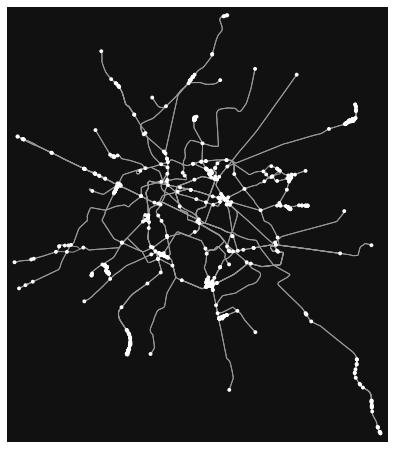

In [24]:
# 配置osmnx
ox.config(use_cache=True, log_console=True)

# 定义巴黎的中心点坐标
paris_location = (48.8566, 2.3522)

# 获取巴黎地铁线路的网络数据
# network_type='all'将会获取所有类型的道路，包括步行街和自行车道
# 但是我们可以通过custom_filter来指定只获取地铁线路
# '["railway"~"subway"]'是一个过滤器，它将只选择railway属性为subway的线路
metro_network = ox.graph_from_point(paris_location, dist=10000, dist_type='bbox', network_type='all', custom_filter='["railway"~"subway"]')

# 绘制网络图
fig, ax = ox.plot_graph(metro_network)
plt.show()

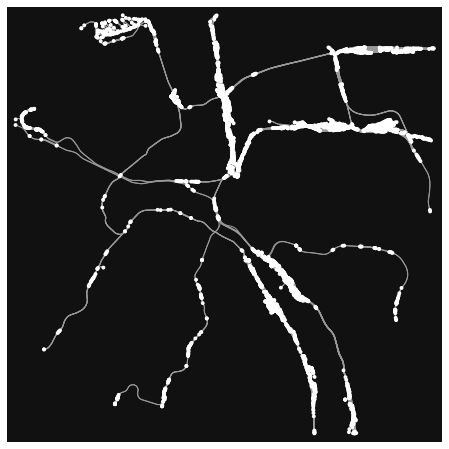

In [25]:
RER_network = ox.graph_from_point(paris_location, dist=10000, dist_type='bbox', network_type='all', custom_filter='["railway"~"rail"]')

# 绘制网络图
fig, ax = ox.plot_graph(RER_network)
plt.show()

In [27]:
# Define the location and network type
place_name = "Paris, France"
network_type = 'all'
custom_filter = '["railway"~"subway"]'

# Create the graph from OSM data
metro_network = ox.graph_from_place(place_name, network_type=network_type, custom_filter=custom_filter)

# Convert the graph to geodataframes
nodes, edges = ox.graph_to_gdfs(metro_network, nodes=True, edges=True)

# Create a folium map centered on Paris
m = folium.Map(location=[48.8566, 2.3522], zoom_start=12)

# Define colors for metro lines
line_colors = {
    'Métro 1': 'blue',
    'Métro 2': 'red',
    'Métro 3': 'green',
    'Métro 4': 'purple',
    'Métro 5': 'orange',
    'Métro 6': 'turquoise',
    'Métro 7': 'pink',
    'Métro 8': 'lightgreen',
    'Métro 9': 'brown',
    'Métro 10': 'lightblue',
    'Métro 11': 'gold',
    'Métro 12': 'navy',
    'Métro 13': 'lavender',
    'Métro 14': 'magenta',
}

# Add metro stations to the map
for idx, row in nodes.iterrows():
    folium.CircleMarker(
        location=(row['y'], row['x']), 
        radius=3, 
        color='black', 
        fill=True
    ).add_to(m)

# Add metro lines to the map with different colors
for idx, row in edges.iterrows():
    geom = row['geometry']
    line_name = row['name'] if type(row['name']) == str else 'Unknown'  # 确保线路名称是字符串
    color = line_colors.get(line_name, 'grey')  # 使用定义好的颜色，如果找不到则默认为灰色

    if geom.geom_type == 'LineString':
        folium.PolyLine(
            locations=[(lat, lon) for lon, lat in geom.coords], 
            color=color, 
            weight=2
        ).add_to(m)
    elif geom.geom_type == 'MultiLineString':
        for line in geom:
            folium.PolyLine(
                locations=[(lat, lon) for lon, lat in line.coords], 
                color=color, 
                weight=2
            ).add_to(m)

# Save and show the map
m.save('paris_metro_stations_and_lines.html')
m


In [10]:
def calculate_walking_distance(G, orig_node, dest_node):
    """
    计算街道网络中两个节点之间的步行距离。

    :param G: 街道网络图。
    :param orig_node: 起始节点。
    :param dest_node: 目的节点。
    :return: 两个节点之间的步行距离（米）。
    """
    try:
        # 计算最短路径的长度
        length = nx.shortest_path_length(G, orig_node, dest_node, weight='length')
        return length
    except nx.NetworkXNoPath:
        print(f"No path between {orig_node} and {dest_node}")
        return None

Straight-line distance from origin to nearest street node: 68.64851095622623 meters
Walking distance from street node to nearest rail node at origin: 363.4000000000001 meters
Rail distance between origin and destination rail nodes: 7282.975999999999 meters
Walking distance from street node to nearest rail node at destination: 606.6120000000001 meters
Straight-line distance from nearest street node to destination: 16.912502072545767 meters
Straight-line distance from origin to destination: 7399.524731641978 meters


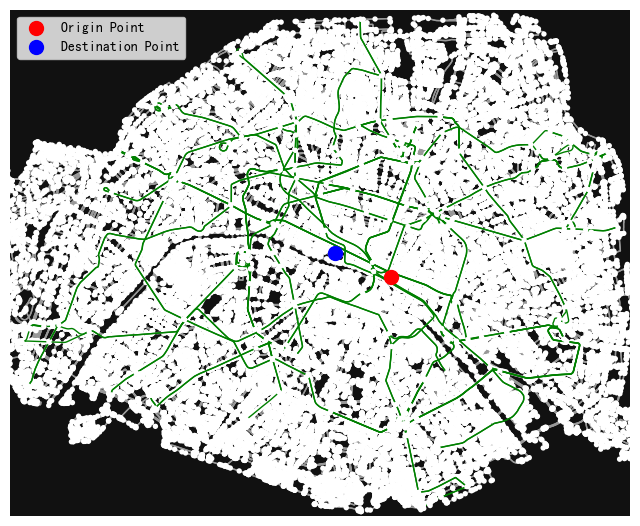

In [18]:
import osmnx as ox
import matplotlib.pyplot as plt
import networkx as nx
import geopy.distance

def calculate_straight_line_distance(point1, point2):
    """计算两点间的直线距离。"""
    return geopy.distance.distance(point1, point2).m

def visualize_network_and_nodes(G_street, G_rail, origin_point, dest_point):
    # 获取最近的街道和铁路站节点
    orig_node_street = ox.distance.nearest_nodes(G_street, origin_point[1], origin_point[0])
    dest_node_street = ox.distance.nearest_nodes(G_street, dest_point[1], dest_point[0])
    orig_node_rail = ox.distance.nearest_nodes(G_rail, origin_point[1], origin_point[0])
    dest_node_rail = ox.distance.nearest_nodes(G_rail, dest_point[1], dest_point[0])
    
    # get the nearest street node to the stations
    orig_street_to_rail = ox.distance.nearest_nodes(G_street, G_rail.nodes[orig_node_rail]['x'], G_rail.nodes[orig_node_rail]['y'])
    dest_street_to_rail = ox.distance.nearest_nodes(G_street, G_rail.nodes[dest_node_rail]['x'], G_rail.nodes[dest_node_rail]['y'])

    # 计算直线距离
    straight_distance_origin = calculate_straight_line_distance(origin_point, (G_street.nodes[orig_node_street]['y'], G_street.nodes[orig_node_street]['x']))
    straight_distance_destination = calculate_straight_line_distance(dest_point, (G_street.nodes[dest_node_street]['y'], G_street.nodes[dest_node_street]['x']))
    straight_orig_station = calculate_straight_line_distance((G_street.nodes[orig_street_to_rail]['y'], G_street.nodes[orig_street_to_rail]['x']), (G_rail.nodes[orig_node_rail]['y'], G_rail.nodes[orig_node_rail]['x']))
    straight_dest_station = calculate_straight_line_distance((G_street.nodes[dest_street_to_rail]['y'], G_street.nodes[dest_street_to_rail]['x']), (G_rail.nodes[dest_node_rail]['y'], G_rail.nodes[dest_node_rail]['x']))

    # 计算步行距离
    walk_distance_origin = calculate_walking_distance(G_street, orig_node_street, orig_street_to_rail)
    walk_distance_destination = calculate_walking_distance(G_street, dest_node_street, dest_street_to_rail)

    # 计算铁路距离
    rail_distance = calculate_walking_distance(G_rail, orig_node_rail, dest_node_rail)

    # 可视化网络和节点
    fig, ax = ox.plot_graph(G_street, show=False, close=False)
    fig, ax = ox.plot_graph(G_rail, ax=ax, edge_color='green', show=False, close=False)

    # 标注起点和终点
    ax.scatter(*origin_point[::-1], c='red', s=100, label='Origin Point')
    ax.scatter(*dest_point[::-1], c='blue', s=100, label='Destination Point')

    # 打印距离
    print(f"Straight-line distance from origin to nearest street node: {straight_distance_origin} meters")
    print(f"Walking distance from street node to nearest rail node at origin: {walk_distance_origin} meters")
    print(f"Rail distance between origin and destination rail nodes: {rail_distance} meters")
    print(f"Walking distance from street node to nearest rail node at destination: {walk_distance_destination} meters")
    print(f"Straight-line distance from nearest street node to destination: {straight_distance_destination} meters")
    print(f"Straight-line distance from origin to destination: {straight_distance_origin + straight_orig_station + rail_distance + straight_dest_station + straight_distance_destination} meters")
    

    plt.legend()
    plt.show()

# 这里需要添加用于计算步行距离的函数 calculate_walking_distance，这个函数你之前已经提供了。
visualize_network_and_nodes(G_street, G_rail, origin_point, dest_point)

